# Baseline model based on anatomy features

Useful links :

- https://brainder.org/2018/01/23/how-do-we-measure-thickness-area-and-volume-of-the-cerebral-cortex/
- https://s3.us-east-2.amazonaws.com/brainder/publications/2010/winkler2010_thickness_area.pdf
    - The results suggest that surface area and cortical thickness measurements should be considered separately and preferred over gray matter volumes for imaging genetic studies.

In [1]:
path = ".."

import sys
sys.path.insert(0, path)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [3]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y, verbose=False):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)
    
    return results


from problem import get_cv


def original_evaluation(X, y, verbose):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)    
    return results

## Preprocess input data

Join train and test

In [4]:
data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)
data_test = pd.concat([data_test_, pd.Series(labels_test_, index=data_test_.index, name='target')], axis=1)

data_train.loc[:, 'is_train'] = 1
data_test.loc[:, 'is_train'] = 0

data = pd.concat([data_train, data_test], axis=0)

In [5]:
data['participants_sex'] = data['participants_sex'].map({'F': -1.0, 'M': +1.0}) 
accepted_anatomy = data['anatomy_select'].isin([1, 2])

In [6]:
data.shape

(1150, 222)

Remove poor QA data

In [7]:
data1 = data[accepted_anatomy].copy()
data1.shape

(1031, 222)

In [8]:
import re 

left_cols = sorted([col for col in data1.columns if col.startswith('anatomy') and re.match(r".+(lh|Left)", col)])

left_cols.remove('anatomy_Left-WM-hypointensities')
left_cols.remove('anatomy_Left-non-WM-hypointensities')

right_cols = []
for c in left_cols:
    if "lh" in c:
        c = c.replace("lh", "rh")
    elif "Left" in c:
        c = c.replace("Left", "Right")
    right_cols.append(c)

anatomy_LR_diff_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]
anatomy_LR_sum_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]

In [9]:
to_remove_anatomy_features = [
    'anatomy_Left-WM-hypointensities',
    'anatomy_Left-non-WM-hypointensities',
    'anatomy_Right-WM-hypointensities',
    'anatomy_Right-non-WM-hypointensities',
    'anatomy_5th-Ventricle', 
    'anatomy_non-WM-hypointensities',
    
    # is L + R   
    'anatomy_CortexVol',
    'anatomy_SurfaceHoles',
    'anatomy_CerebralWhiteMatterVol',
    
    # Correlated with others
    'anatomy_EstimatedTotalIntraCranialVol',
    'anatomy_SupraTentorialVolNotVentVox',
]

In [10]:
anatomy_cols = [col for col in data1.columns if col.startswith('anatomy')]

anatomy_cols.remove('anatomy_select')

for c in to_remove_anatomy_features:
    anatomy_cols.remove(c)

participant_cols = [col for col in data1.columns if col.startswith('participant')]
participant_cols.remove('participants_site')

In [11]:
len(anatomy_cols)

196

In [12]:
anatomy_diff_cols = []
anatomy_sum_cols = []
to_remove_anatomy_diff_cols = []


for c1, c2 in anatomy_LR_diff_cols:
    data1.loc[:, "({} - {})".format(c1, c2)] = data1[c1] - data1[c2]
    anatomy_diff_cols.append("({} - {})".format(c1, c2))
    to_remove_anatomy_diff_cols.append(c1)
    to_remove_anatomy_diff_cols.append(c2)    

    
for c1, c2 in anatomy_LR_sum_cols:
    data1.loc[:, "({} + {})".format(c1, c2)] = data1[c1] + data1[c2]
    anatomy_sum_cols.append("({} + {})".format(c1, c2))
    

for c in to_remove_anatomy_diff_cols:
    anatomy_cols.remove(c)    

In [13]:
len(anatomy_diff_cols), len(anatomy_sum_cols)

(87, 87)

In [14]:
data1.shape

(1031, 396)

Rescale features:

- age -> age / 100 in [0.0, 1.0]
- others -> feature / std(feature)

In [15]:
data1.loc[:, 'participants_age'] = data1['participants_age'] / 100.0

In [16]:
cols = anatomy_cols + anatomy_sum_cols + anatomy_diff_cols

for c in cols:
    mean = data1[c].mean(axis=0)
    std = data1[c].std(axis=0)
    data1.loc[:, c] = (data1[c] - mean) / (std + 1e-10)

In [17]:
data1[cols].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106               -0.870088              -0.453870   
5174041730092253771                0.481827               0.387652   
10219322676643534800               0.018766               0.871654   
10645466564919190227              -1.234432               0.106618   
14512541342641936232              -1.486974              -0.744902   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106            -0.902611    -0.772524   
5174041730092253771             1.277819     0.372575   
10219322676643534800            0.015354    -0.336677   
10645466564919190227           -1.142759    -1.237937   
14512541342641936232            0.642256    -0.719304   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                    -1.171588              1.877849   
5174041730092253771                    -0.890742             -0.092810   
10219322676643534800                   -0.847351              0.729113   
10645466564919190227                    0.392028              0.046134   
14512541342641936232                   -0.766547             -0.096724   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106              -0.901757                 -0.607991   
5174041730092253771              -0.051478                  0.691110   
10219322676643534800             -0.146870                  0.108180   
10645466564919190227             -1.286855                  0.351531   
14512541342641936232              1.228061                  0.644846   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106            -1.017174                -1.189958   
5174041730092253771            -0.469022                -0.501704   
10219322676643534800            1.125542                 1.431320   
10645466564919190227           -0.268100                -0.865431   
14512541342641936232            2.392428                 2.789193   

                                                             ...                                           \
subject_id                                                   ...                                            
1932355398536124106                                          ...                                            
5174041730092253771                                          ...                                            
10219322676643534800                                         ...                                            
10645466564919190227                                         ...                                            
14512541342641936232                                         ...                                            

                      (anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area)  \
subject_id                                                                                    
1932355398536124106                                            0.186539                       
5174041730092253771                                           -0.030007                       
10219322676643534800                                          -0.261884                       
10645466564919190227                                          -1.143401                       
14512541342641936232                                           0.424166                       

                      (anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness)  \
subject_id                                                                              

### Feature extraction and filtering

In [20]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

### Single features filtering by model feature importance

In [23]:
cols = anatomy_cols + anatomy_diff_cols + anatomy_sum_cols + participant_cols

In [24]:
from sklearn.linear_model import LogisticRegression

n_jobs=1
seed = 42
        

log_reg = LogisticRegression(random_state=seed)
log_reg.fit(data1[cols], data1['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

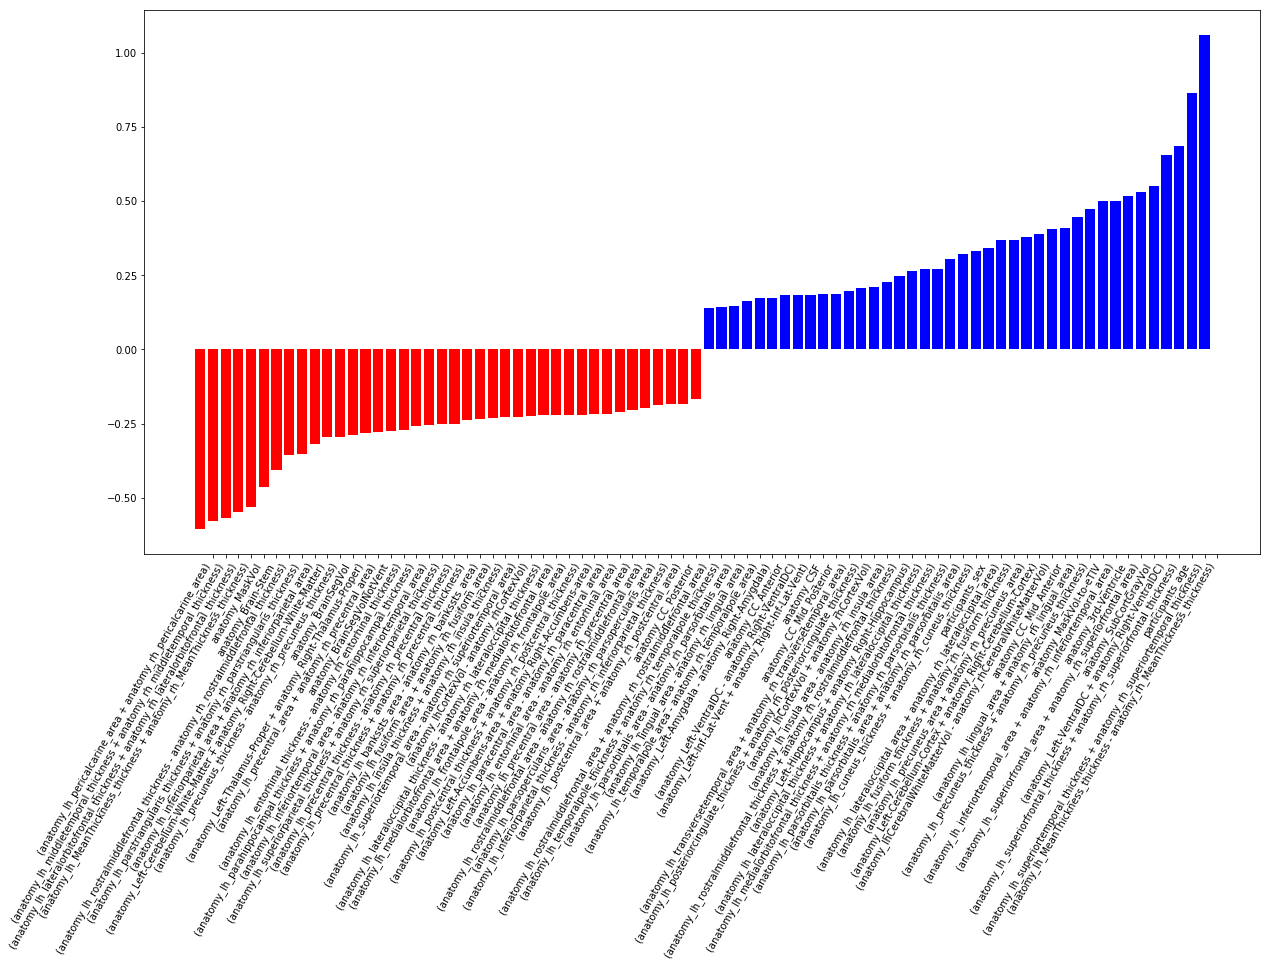

In [25]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [26]:
coef = log_reg.coef_.ravel()

In [27]:
coef.min(), coef.max(), np.abs(coef).min()

(-0.6067937547254811, 1.0599401577220353, 0.0018064510720514813)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


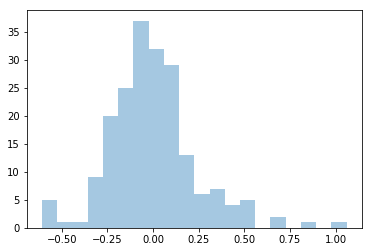

In [28]:
sns.distplot(coef, kde=False)

In [29]:
from itertools import product

In [30]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search

In [35]:
neg_thresholds = np.linspace(-0.20, -0.17, 12)
pos_thresholds = np.linspace(0.10, 0.15, 12)

In [36]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 30
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" -> ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()
        
    results = evaluation(data1[top_1_selected_columns], data1['target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.2 0.1 -> 0.7050632911392405
Trial:  1 -0.2 0.10454545454545455 -> 0.7042965382695885
Trial:  2 -0.2 0.1090909090909091 -> 0.7067858385130741
Trial:  3 -0.2 0.11363636363636365 -> 0.7071850944452006
Trial:  4 -0.2 0.11818181818181818 -> 0.7093991500688113
Trial:  5 -0.2 0.12272727272727273 -> 0.7106256521936392
Trial:  6 -0.2 0.12727272727272726 -> 0.7106256521936392
Trial:  7 -0.2 0.1318181818181818 -> 0.7102052235984453
Trial:  8 -0.2 0.13636363636363635 -> 0.7106090165298005
Trial:  9 -0.2 0.1409090909090909 -> 0.7084221829015622
Trial:  10 -0.2 0.14545454545454545 -> 0.7088728581582808
Trial:  11 -0.2 0.15 -> 0.7091057574520213
Trial:  12 -0.1972727272727273 0.1 -> 0.705858778337341
Trial:  13 -0.1972727272727273 0.10454545454545455 -> 0.7070414228029581
Trial:  14 -0.1972727272727273 0.1090909090909091 -> 0.7080365379671218
Trial:  15 -0.1972727272727273 0.11363636363636365 -> 0.7097999183340139
Trial:  16 -0.1972727272727273 0.11818181818181818 -> 0.7100509656246692
T

In [37]:
best_thresholds

(-0.1972727272727273, 0.13636363636363635)

In [39]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(positive_coefficients), len(negative_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = evaluation(data1[top_1_selected_columns], data1['target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.1972727272727273 0.13636363636363635
41 36 198
Training score ROC-AUC: 0.845 +- 0.012
Validation score ROC-AUC: 0.712 +- 0.015 

Training score accuracy: 0.767 +- 0.013
Validation score accuracy: 0.655 +- 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.8s finished



```
-0.1972727272727273 0.13636363636363635
41 36 198

Training score ROC-AUC: 0.845 +- 0.012
Validation score ROC-AUC: 0.712 +- 0.015 

Training score accuracy: 0.767 +- 0.013
Validation score accuracy: 0.655 +- 0.019

```

In [40]:
print("[", end="")
for f in top_1_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_Brain-Stem", "anatomy_BrainSegVol", "anatomy_MaskVol", "anatomy_BrainSegVolNotVent", "(anatomy_lhCortexVol - anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_rostralmiddlefrontal_

In [43]:


f1_columns = ["anatomy_Brain-Stem", "anatomy_BrainSegVol", "anatomy_MaskVol", "anatomy_BrainSegVolNotVent", "(anatomy_lhCortexVol - anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "anatomy_3rd-Ventricle", "anatomy_CSF", "anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior", "anatomy_SubCortGrayVol", "anatomy_MaskVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "participants_sex", "participants_age", ]

len(f1_columns)


77

Polynomial 2nd degree



In [44]:
train_columns = f1_columns

In [45]:
data_ = data1[train_columns].values
data_.shape

(1031, 77)

In [46]:
pairs_columns = []

n = len(train_columns) * (len(train_columns) - 1)

pairs_data = np.zeros((len(data_), n))

c = 0
for i, f1 in enumerate(train_columns):
    
    for j, f2 in enumerate(train_columns):
        if i < j:
            pairs_columns.append("{} x {}".format(f1, f2))
            pairs_data[:, c] = data_[:, i] * data_[:, j]
            c += 1
            
            pairs_columns.append("{} / {}".format(f1, f2))
            pairs_data[:, c] = data_[:, i] / (data_[:, j] + 1e-10)
            c += 1

In [47]:
pairs_df = pd.DataFrame(pairs_data, columns=pairs_columns, index=data1.index)

In [48]:
pairs_columns = pairs_df.columns.values.tolist()
pairs_df.shape

(1031, 5852)

In [49]:
data2 = pd.concat([data1, pairs_df], axis=1)

In [50]:
train_columns = anatomy_cols + anatomy_diff_cols + anatomy_sum_cols + participant_cols + pairs_columns
len(train_columns)

6050

In [51]:
data2[train_columns].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106               -0.870088              -0.453870   
5174041730092253771                0.481827               0.387652   
10219322676643534800               0.018766               0.871654   
10645466564919190227              -1.234432               0.106618   
14512541342641936232              -1.486974              -0.744902   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106            -0.902611    -0.772524   
5174041730092253771             1.277819     0.372575   
10219322676643534800            0.015354    -0.336677   
10645466564919190227           -1.142759    -1.237937   
14512541342641936232            0.642256    -0.719304   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                    -1.171588              1.877849   
5174041730092253771                    -0.890742             -0.092810   
10219322676643534800                   -0.847351              0.729113   
10645466564919190227                    0.392028              0.046134   
14512541342641936232                   -0.766547             -0.096724   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106              -0.901757                 -0.607991   
5174041730092253771              -0.051478                  0.691110   
10219322676643534800             -0.146870                  0.108180   
10645466564919190227             -1.286855                  0.351531   
14512541342641936232              1.228061                  0.644846   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106            -1.017174                -1.189958   
5174041730092253771            -0.469022                -0.501704   
10219322676643534800            1.125542                 1.431320   
10645466564919190227           -0.268100                -0.865431   
14512541342641936232            2.392428                 2.789193   

                                     ...                   \
subject_id                           ...                    
1932355398536124106                  ...                    
5174041730092253771                  ...                    
10219322676643534800                 ...                    
10645466564919190227                 ...                    
14512541342641936232                 ...                    

                      (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex  \
subject_id                                                                                                         
1932355398536124106                                           -1.346769                                            
5174041730092253771                                            1.394699                                            
10219322676643534800                                           0.879783                                            
10645466564919190227                                           0.335128                                            
14512541342641936232                                           1.573346                                            

                      (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex  \
subject_id                                                                                                         
1932355398536124106                                           -1.346769                                            
5174041730092253771               

In [52]:
for c in pairs_columns:
    mean = data2[c].mean(axis=0)
    std = data2[c].std(axis=0)
    data2.loc[:, c] = (data2[c] - mean) / (std + 1e-10)

### Double features filtering by model feature importance

In [53]:
cols = pairs_columns

In [54]:
from sklearn.linear_model import LogisticRegression

n_jobs=1
seed = 42
        

log_reg = LogisticRegression(random_state=seed)
log_reg.fit(data2[cols], data2['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

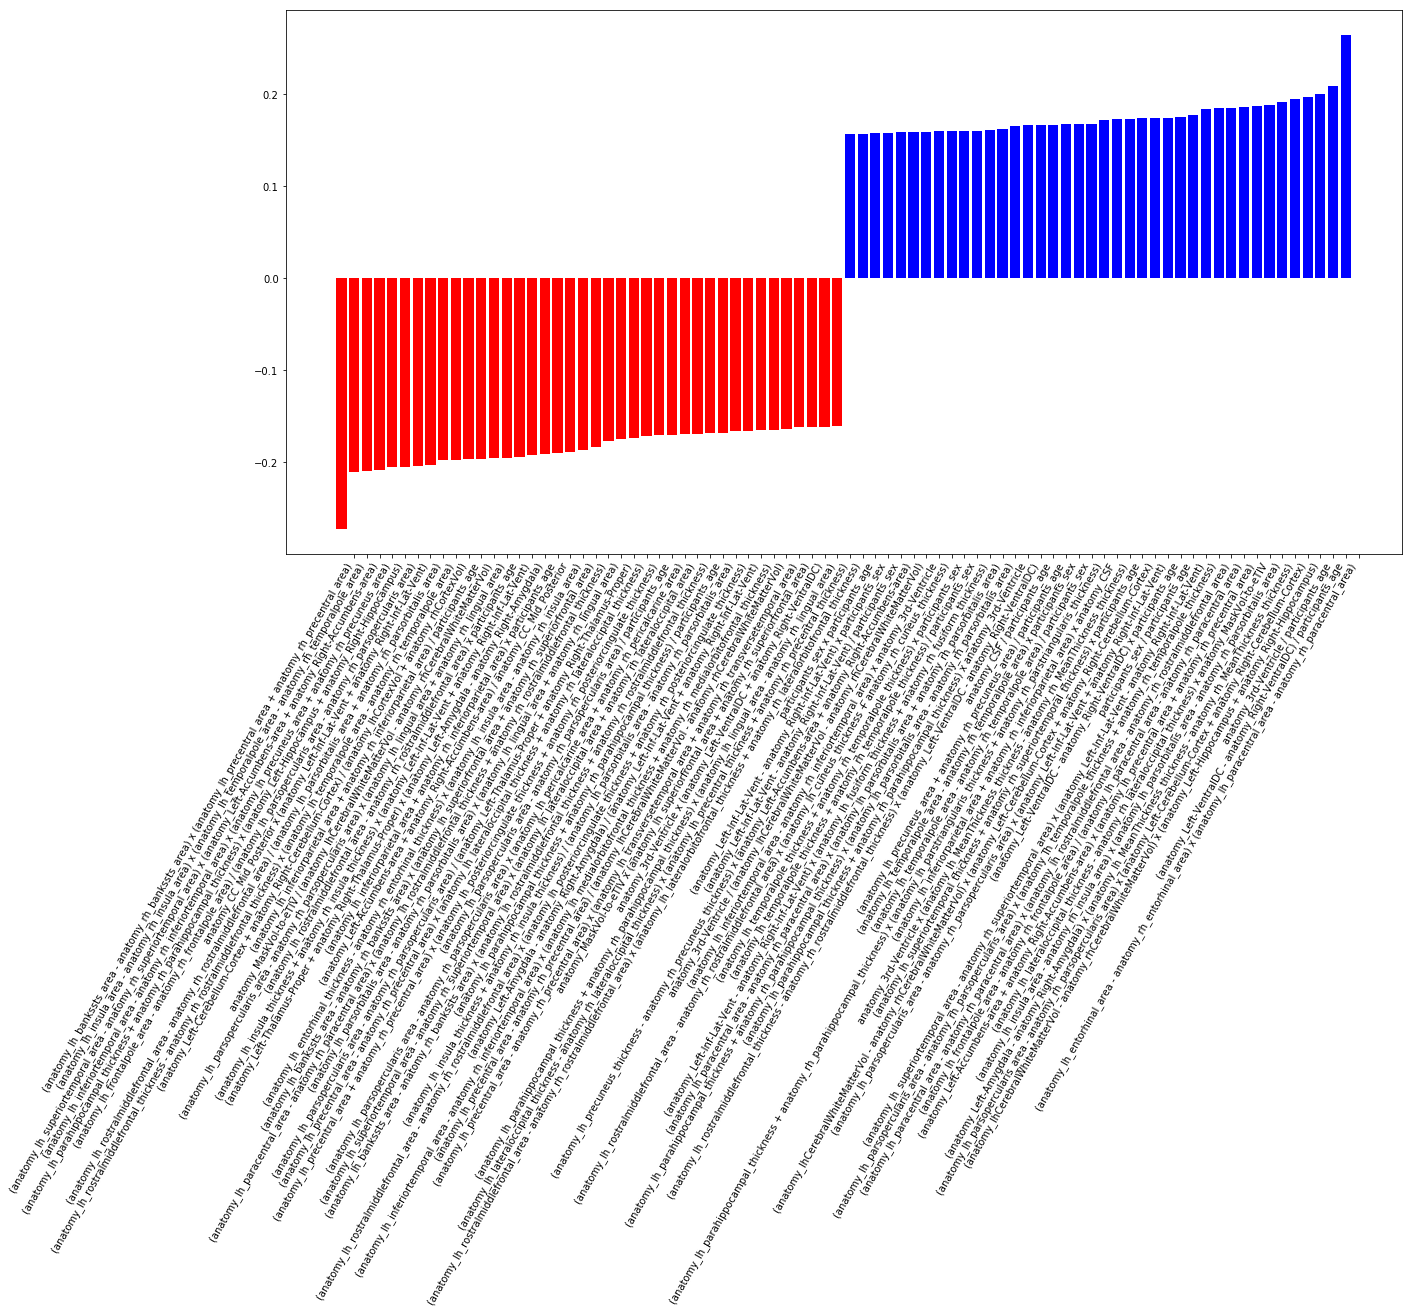

In [55]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [56]:
coef = log_reg.coef_.ravel()

In [57]:
coef.min(), coef.max(), np.abs(coef).min()

(-0.27230952638163114, 0.2642010803360375, 9.277505680992657e-06)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


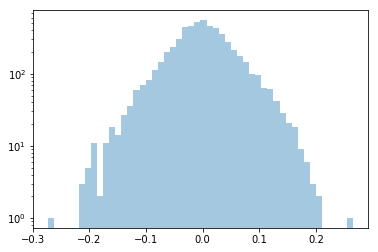

In [58]:
sns.distplot(coef, kde=False)
plt.yscale('log')

In [59]:
from itertools import product

In [60]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search

In [61]:
neg_thresholds = np.linspace(-0.01, -0.10, 12)
pos_thresholds = np.linspace(0.01, 0.10, 12)

In [63]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 30
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" -> ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_2_selected_columns = np.array(cols)[interesting_coefficients].tolist()
        
    results = evaluation(data2[top_2_selected_columns], data2['target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.01 0.01 -> 0.6067760083480787
Trial:  1 -0.01 0.01818181818181818 -> 0.6287131557854301
Trial:  2 -0.01 0.026363636363636367 -> 0.6470191915067374
Trial:  3 -0.01 0.034545454545454546 -> 0.6638998533036916
Trial:  4 -0.01 0.04272727272727273 -> 0.6739969450871859
Trial:  5 -0.01 0.05090909090909091 -> 0.6804001633319723
Trial:  6 -0.01 0.0590909090909091 -> 0.6809015017467448
Trial:  7 -0.01 0.06727272727272728 -> 0.6767047774601878
Trial:  8 -0.01 0.07545454545454545 -> 0.6762503213707787
Trial:  9 -0.01 0.08363636363636363 -> 0.6650114181147255
Trial:  10 -0.01 0.09181818181818181 -> 0.65489466600124
Trial:  11 -0.01 0.1 -> 0.6411135308440331
Trial:  12 -0.01818181818181818 0.01 -> 0.6233148828698033
Trial:  13 -0.01818181818181818 0.01818181818181818 -> 0.651047290655294
Trial:  14 -0.01818181818181818 0.026363636363636367 -> 0.671448663853727
Trial:  15 -0.01818181818181818 0.034545454545454546 -> 0.6919453140359633
Trial:  16 -0.01818181818181818 0.04272727272727273 -

Trial:  117 -0.08363636363636363 0.08363636363636363 -> 0.855622854377448
Trial:  118 -0.08363636363636363 0.09181818181818181 -> 0.8510147754941549
Trial:  119 -0.08363636363636363 0.1 -> 0.8403218244786231
Trial:  120 -0.09181818181818181 0.01 -> 0.6451000408329931
Trial:  121 -0.09181818181818181 0.01818181818181818 -> 0.6787736491084796
Trial:  122 -0.09181818181818181 0.026363636363636367 -> 0.7123557612328539
Trial:  123 -0.09181818181818181 0.034545454545454546 -> 0.7542201654492386
Trial:  124 -0.09181818181818181 0.04272727272727273 -> 0.7823903936602996
Trial:  125 -0.09181818181818181 0.05090909090909091 -> 0.806351042753656
Trial:  126 -0.09181818181818181 0.0590909090909091 -> 0.8161819639157327
Trial:  127 -0.09181818181818181 0.06727272727272728 -> 0.8289528605780137
Trial:  128 -0.09181818181818181 0.07545454545454545 -> 0.8470607806663338
Trial:  129 -0.09181818181818181 0.08363636363636363 -> 0.849214342966895
Trial:  130 -0.09181818181818181 0.09181818181818181 -> 0.

In [64]:
best_thresholds

(-0.07545454545454545, 0.08363636363636363)

In [66]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(positive_coefficients), len(negative_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_2_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = evaluation(data2[top_2_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.07545454545454545 0.08363636363636363
434 496 5852
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.863 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.794 +- 0.017



```
-0.07545454545454545 0.08363636363636363
434 496 5852
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.863 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.794 +- 0.017
```

In [67]:
print("[", end="")
for f in top_2_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol)", "anatomy_Brain-Stem / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "anatomy_Brain-Stem / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_Brain-Stem x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_Brain-Stem / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_Brain-Stem x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_Brain-Stem x participants_age", "anatomy_Brain-Stem / participants_age", "anatomy_BrainSegVol / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVol x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_BrainSegVol x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_BrainSegVol x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_media

In [31]:
(data2[train_columns] > 1e5).any().any()

False

In [37]:
(data2[train_columns].std(axis=0) < 0.01).any()

False

In [32]:
data2[train_columns].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106                2.794620               2.882258   
5174041730092253771                4.146536               3.723780   
10219322676643534800               3.683475               4.207782   
10645466564919190227               2.430277               3.442746   
14512541342641936232               2.177734               2.591226   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106             6.851331     2.560470   
5174041730092253771             9.031761     3.705569   
10219322676643534800            7.769296     2.996317   
10645466564919190227            6.611183     2.095057   
14512541342641936232            8.396198     2.613690   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                     0.909504              5.160506   
5174041730092253771                     1.190350              3.189846   
10219322676643534800                    1.233741              4.011770   
10645466564919190227                    2.473119              3.328790   
14512541342641936232                    1.314544              3.185932   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106               4.461017                  4.280372   
5174041730092253771               5.311295                  5.579474   
10219322676643534800              5.215904                  4.996544   
10645466564919190227              4.075918                  5.239894   
14512541342641936232              6.590834                  5.533209   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106             3.007759                 2.575652   
5174041730092253771             3.555911                 3.263907   
10219322676643534800            5.150475                 5.196931   
10645466564919190227            3.756833                 2.900179   
14512541342641936232            6.417361                 6.554804   

                                                                       ...                                                    \
subject_id                                                             ...                                                     
1932355398536124106                                                    ...                                                     
5174041730092253771                                                    ...                                                     
10219322676643534800                                                   ...                                                     
10645466564919190227                                                   ...                                                     
14512541342641936232                                                   ...                                                     

                      (anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness) x (anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness)  \
subject_id                                                                                                                                                                            
1932355398536124106                                            0.223598                                                                                                               
5174041730092253771                                            0.509822                                                                                                          

Polynomial 3nd degree



In [38]:
cols = [c for c in pairs_columns if " + " in c or " - " in c]

In [39]:
cols[-10:]

['(anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness) x (anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness)',
 '(anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness) / (anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness)',
 '(anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness) x participants_age',
 '(anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness) / participants_age',
 '(anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area) x (anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness)',
 '(anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area) / (anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness)',
 '(anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area) x participants_age',
 '(anatomy_lh_transversetemporal_area - anatomy_rh_transverse

In [40]:
data_ = data2[cols].values
data_.shape

(1031, 38106)

In [41]:
triplet_columns = []

n = len(cols) * (len(anatomy_cols) )

triplet_data = np.zeros((len(data_), n))

c = 0
for i, f1 in enumerate(cols):    
    for j, f2 in enumerate(anatomy_cols):
        triplet_columns.append("{} x {}".format(f1, f2))
        triplet_data[:, c] = data_[:, i] * data_[:, j]
        c += 1

In [42]:
triplet_data.shape, len(triplet_columns)

((1031, 838332), 838332)

In [43]:
triplet_df = pd.DataFrame(triplet_data, columns=triplet_columns, index=data2.index)

In [44]:
triplet_columns = triplet_df.columns.values.tolist()
triplet_df.shape

(1031, 838332)

In [45]:
data3 = pd.concat([data2, triplet_df], axis=1)

In [46]:
train_columns = anatomy_cols + anatomy_diff_cols + anatomy_sum_cols + participant_cols + pairs_columns + triplet_columns
len(train_columns)

877142

In [47]:
data3[train_columns].head()

anatomy_3rd-Ventricle  anatomy_4th-Ventricle  \
subject_id                                                           
1932355398536124106                2.794620               2.882258   
5174041730092253771                4.146536               3.723780   
10219322676643534800               3.683475               4.207782   
10645466564919190227               2.430277               3.442746   
14512541342641936232               2.177734               2.591226   

                      anatomy_Brain-Stem  anatomy_CSF  \
subject_id                                              
1932355398536124106             6.851331     2.560470   
5174041730092253771             9.031761     3.705569   
10219322676643534800            7.769296     2.996317   
10645466564919190227            6.611183     2.095057   
14512541342641936232            8.396198     2.613690   

                      anatomy_WM-hypointensities  anatomy_Optic-Chiasm  \
subject_id                                                               
1932355398536124106                     0.909504              5.160506   
5174041730092253771                     1.190350              3.189846   
10219322676643534800                    1.233741              4.011770   
10645466564919190227                    2.473119              3.328790   
14512541342641936232                    1.314544              3.185932   

                      anatomy_CC_Posterior  anatomy_CC_Mid_Posterior  \
subject_id                                                             
1932355398536124106               4.461017                  4.280372   
5174041730092253771               5.311295                  5.579474   
10219322676643534800              5.215904                  4.996544   
10645466564919190227              4.075918                  5.239894   
14512541342641936232              6.590834                  5.533209   

                      anatomy_CC_Central  anatomy_CC_Mid_Anterior  \
subject_id                                                          
1932355398536124106             3.007759                 2.575652   
5174041730092253771             3.555911                 3.263907   
10219322676643534800            5.150475                 5.196931   
10645466564919190227            3.756833                 2.900179   
14512541342641936232            6.417361                 6.554804   

                                                                                     ...                                                                   \
subject_id                                                                           ...                                                                    
1932355398536124106                                                                  ...                                                                    
5174041730092253771                                                                  ...                                                                    
10219322676643534800                                                                 ...                                                                    
10645466564919190227                                                                 ...                                                                    
14512541342641936232                                                                 ...                                                                    

                      (anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness) / participants_age x anatomy_BrainSegVolNotVentSurf  \
subject_id                                                                                                                                                      
1932355398536124106                                            1.554154                                                                                         
5174041730092253771                     

In [48]:
(data3[train_columns].std(axis=0) < 0.01).any()

False

### Feature extraction and filtering

In [34]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [58]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

n_jobs=1
seed = 42


class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier0(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), 
                                 LogisticRegression(random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [59]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y, verbose=False):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)
    
    return results


from problem import get_cv


def original_evaluation(X, y, verbose):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)    
    return results

### Single features filtering by model feature importance

In [37]:
cols = anatomy_cols + anatomy_diff_cols + anatomy_sum_cols + participant_cols

In [38]:
pipe = make_pipeline(FeatureExtractor(), Classifier0())
pipe.fit(data3[cols], data3['target'])

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [39]:
log_reg = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

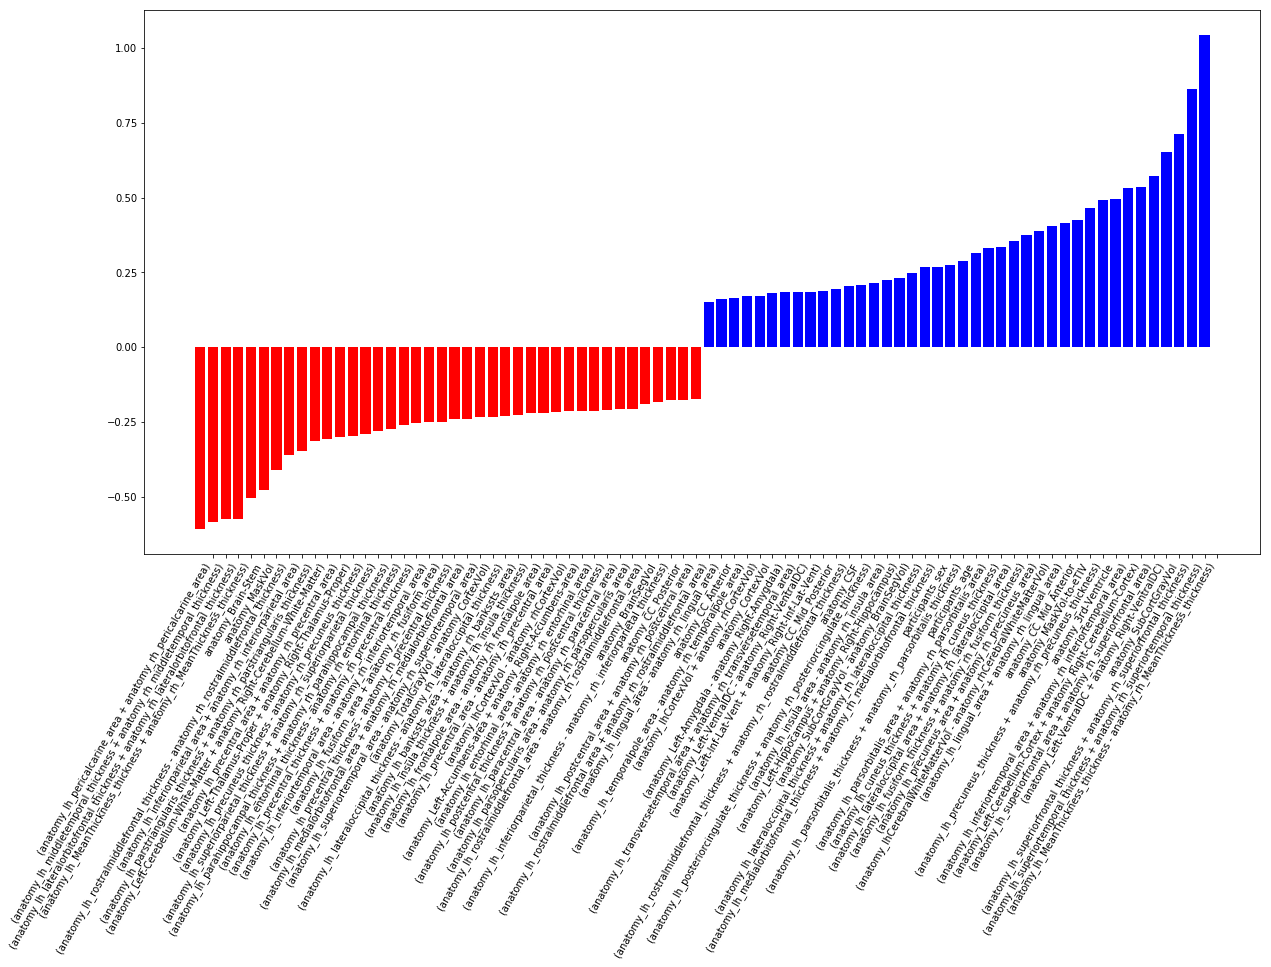

In [40]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [41]:
coef = log_reg.coef_.ravel()

In [42]:
coef.min(), coef.max(), np.abs(coef).min()

(-0.6094533027191741, 1.0432773952778944, 0.0002602947834041592)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


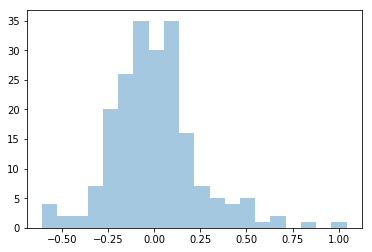

In [43]:
sns.distplot(coef, kde=False)

In [44]:
from itertools import product

In [45]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search

In [46]:
neg_thresholds = np.linspace(-0.22, -0.13, 12)
pos_thresholds = np.linspace(0.1, 0.25, 12)

In [47]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 30
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" -> ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()
        
    results = evaluation(data3[top_1_selected_columns], data3['target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.22 0.1 -> 0.6963401539555071
Trial:  1 -0.22 0.11363636363636365 -> 0.6974063487742541
Trial:  2 -0.22 0.1272727272727273 -> 0.7017679173661207
Trial:  3 -0.22 0.14090909090909093 -> 0.6992907157872449
Trial:  4 -0.22 0.15454545454545454 -> 0.6999122846815782
Trial:  5 -0.22 0.16818181818181818 -> 0.6994585847587074
Trial:  6 -0.22 0.18181818181818182 -> 0.6997413910439636
Trial:  7 -0.22 0.19545454545454544 -> 0.6884442629644754
Trial:  8 -0.22 0.2090909090909091 -> 0.6886559895951485
Trial:  9 -0.22 0.22272727272727272 -> 0.6871769278465889
Trial:  10 -0.22 0.23636363636363636 -> 0.6869818368797544
Trial:  11 -0.22 0.25 -> 0.6829030745731439
Trial:  12 -0.21181818181818182 0.1 -> 0.7021928829605432
Trial:  13 -0.21181818181818182 0.11363636363636365 -> 0.7054746457359768
Trial:  14 -0.21181818181818182 0.1272727272727273 -> 0.7083783252423513
Trial:  15 -0.21181818181818182 0.14090909090909093 -> 0.7063638975848041
Trial:  16 -0.21181818181818182 0.15454545454545454 -> 0

In [52]:
best_thresholds = (-0.18727272727272729, 0.1272727272727273)

In [54]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(positive_coefficients), len(negative_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = evaluation(data3[top_1_selected_columns], data2['target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.18727272727272729 0.1272727272727273
44 36 203
Training score ROC-AUC: 0.845 +- 0.011
Validation score ROC-AUC: 0.712 +- 0.016 

Training score accuracy: 0.766 +- 0.012
Validation score accuracy: 0.655 +- 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished



```
-0.18727272727272729 0.1272727272727273
44 36 203

Training score ROC-AUC: 0.845 +- 0.011
Validation score ROC-AUC: 0.712 +- 0.016 

Training score accuracy: 0.766 +- 0.012
Validation score accuracy: 0.655 +- 0.019
```

In [55]:
print("[", end="")
for f in top_1_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_Brain-Stem", "anatomy_BrainSegVol", "anatomy_MaskVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostral

### Double features filtering by model feature importance

In [56]:
cols = pairs_columns

In [60]:
pipe = make_pipeline(FeatureExtractor(), Classifier0())
pipe.fit(data3[cols], data3['target'])

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier0', Classifier0())])

In [62]:
log_reg = pipe.named_steps['classifier0'].clf.named_steps['logisticregression']

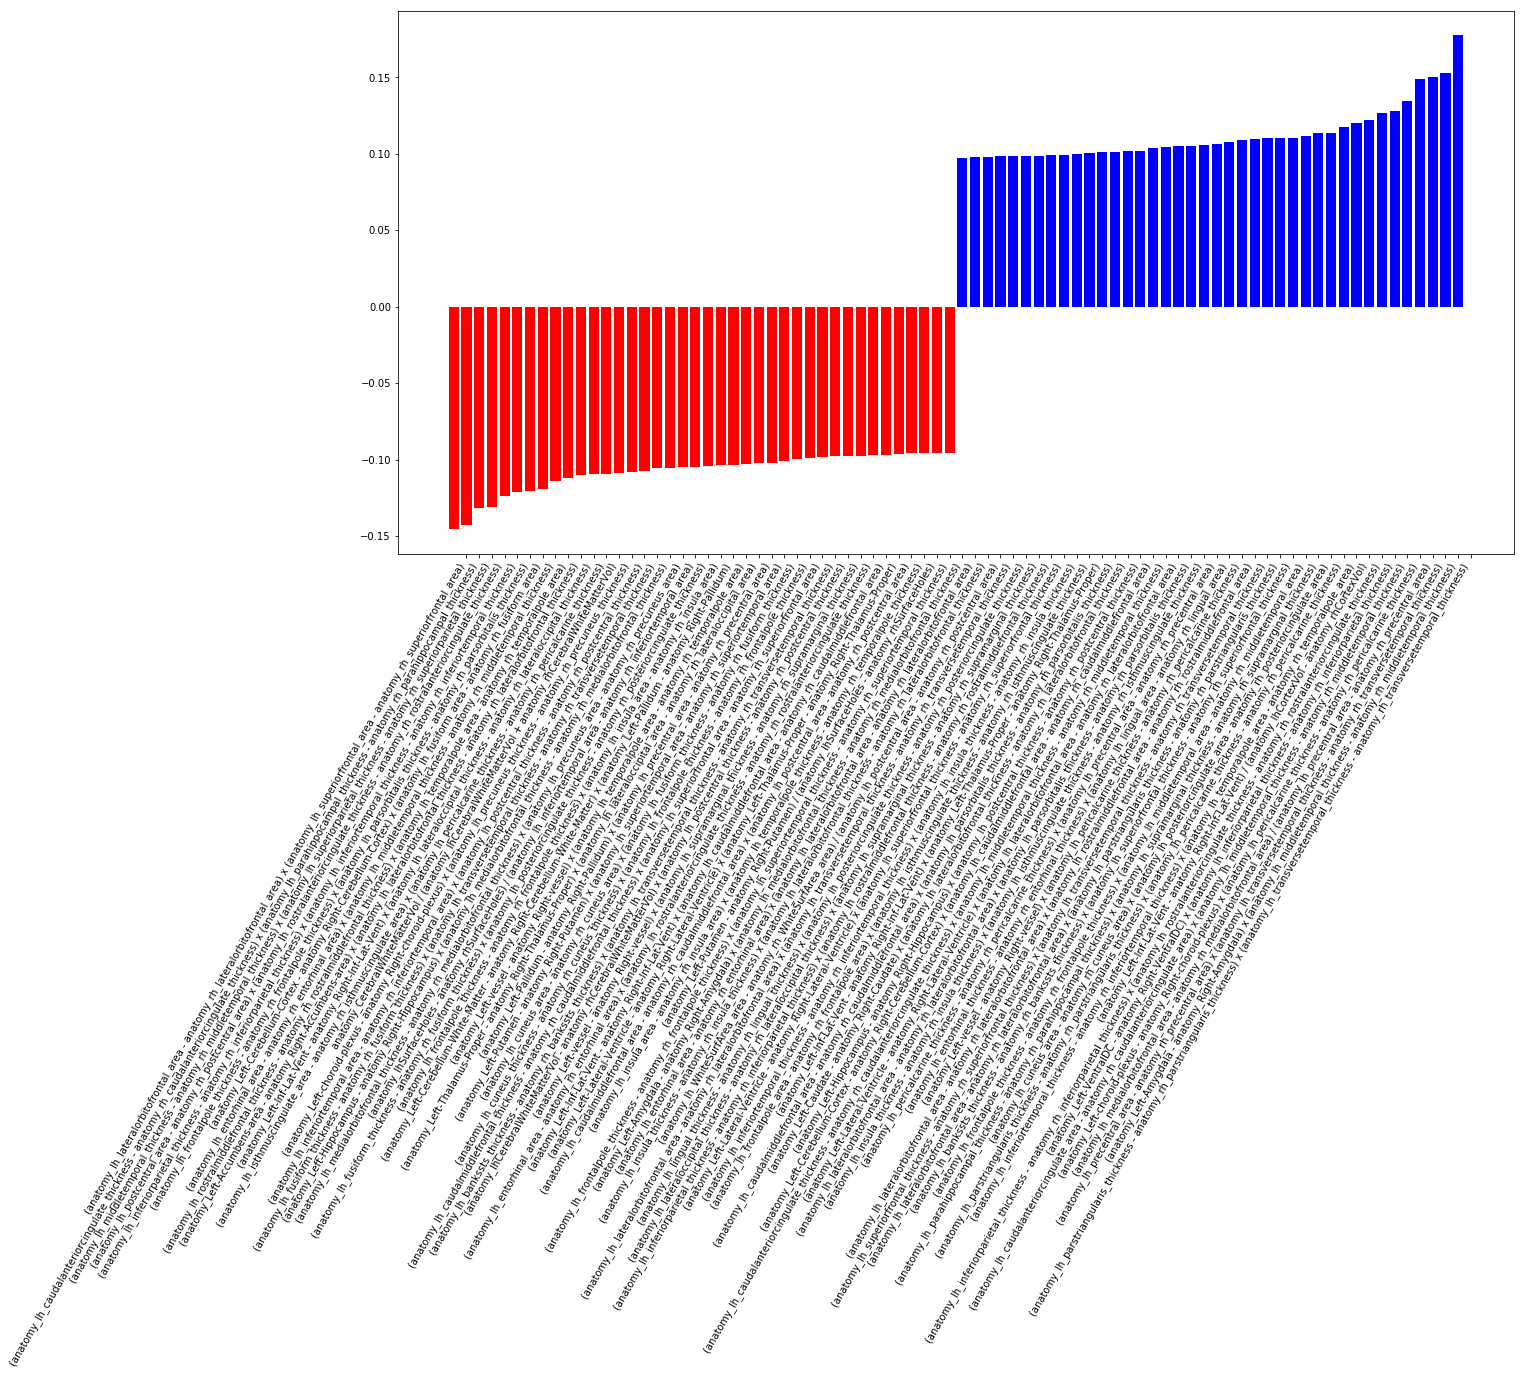

In [63]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [64]:
coef = log_reg.coef_.ravel()

In [65]:
coef.min(), coef.max(), np.abs(coef).min()

(-0.1456426397618491, 0.1775864533386721, 3.3676403178809085e-07)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


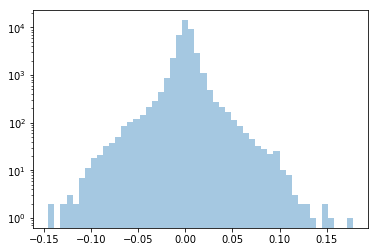

In [72]:
sns.distplot(coef, kde=False)
plt.yscale('log')

In [67]:
from itertools import product

In [68]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search

In [73]:
neg_thresholds = np.linspace(-0.01, -0.10, 12)
pos_thresholds = np.linspace(0.01, 0.10, 12)

In [74]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 30
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" -> ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_2_selected_columns = np.array(cols)[interesting_coefficients].tolist()
        
    results = evaluation(data3[top_2_selected_columns], data3['target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.01 0.01 -> 0.7095488710433586
Trial:  1 -0.01 0.01818181818181818 -> 0.7304833416511652
Trial:  2 -0.01 0.026363636363636367 -> 0.7165781951817067
Trial:  3 -0.01 0.034545454545454546 -> 0.712528167203545
Trial:  4 -0.01 0.04272727272727273 -> 0.7087450660133389
Trial:  5 -0.01 0.05090909090909091 -> 0.7021754911301665
Trial:  6 -0.01 0.0590909090909091 -> 0.6936890340728643
Trial:  7 -0.01 0.06727272727272728 -> 0.6875315699529664
Trial:  8 -0.01 0.07545454545454545 -> 0.6776900624593561
Trial:  9 -0.01 0.08363636363636363 -> 0.6633992710554573
Trial:  10 -0.01 0.09181818181818181 -> 0.6519524220014216
Trial:  11 -0.01 0.1 -> 0.6367678417494669
Trial:  12 -0.01818181818181818 0.01 -> 0.719166553241686
Trial:  13 -0.01818181818181818 0.01818181818181818 -> 0.7687506616457208
Trial:  14 -0.01818181818181818 0.026363636363636367 -> 0.7497655883731834
Trial:  15 -0.01818181818181818 0.034545454545454546 -> 0.7355557067888631
Trial:  16 -0.01818181818181818 0.04272727272727273

In [75]:
best_thresholds

(-0.04272727272727273, 0.01818181818181818)

In [76]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(positive_coefficients), len(negative_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_2_selected_columns = np.array(cols)[interesting_coefficients].tolist()

results = evaluation(data3[top_2_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-0.04272727272727273 0.01818181818181818
2149 624 40602
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.789 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.723 +- 0.019



```
-0.03932351273569926 0.022553479574011357
1576 716 40602

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.773 +- 0.013 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.714 +- 0.014
```

In [77]:
print("[", end="")
for f in top_2_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_4th-Ventricle x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "anatomy_WM-hypointensities x (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_CerebralWhiteMatterVol / (anatomy_lhCerebralWhiteMatterVol + anatomy_rhCerebralWhiteMatterVol)", "anatomy_SurfaceHoles x (anatomy_Left-Caudate - anatomy_Right-Caudate)", "anatomy_SurfaceHoles / (anatomy_lhSurfaceHoles - anatomy_rhSurfaceHoles)", "anatomy_SurfaceHoles x (anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness)", "anatomy_SurfaceHoles x (anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_frontalpole_thickness - anatomy_rh_frontalpole_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_Left-vessel + anatomy_Right-vessel) x (anatomy_Left-Cerebellum-Whit

"(anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness) x (anatomy_lh_rostralanteriorcingulate_thickness - anatomy_rh_rostralanteriorcingulate_thickness)", "(anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness) x (anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness) x (anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area)", "(anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness) x (anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness)", "(anatom

### Triplet features filtering by model feature importance

In [78]:
cols = triplet_columns

In [ ]:
pipe = make_pipeline(FeatureExtractor(), Classifier0())
pipe.fit(data3[cols], data3['target'])

In [ ]:
log_reg = pipe.named_steps['classifier0'].clf.named_steps['logisticregression']

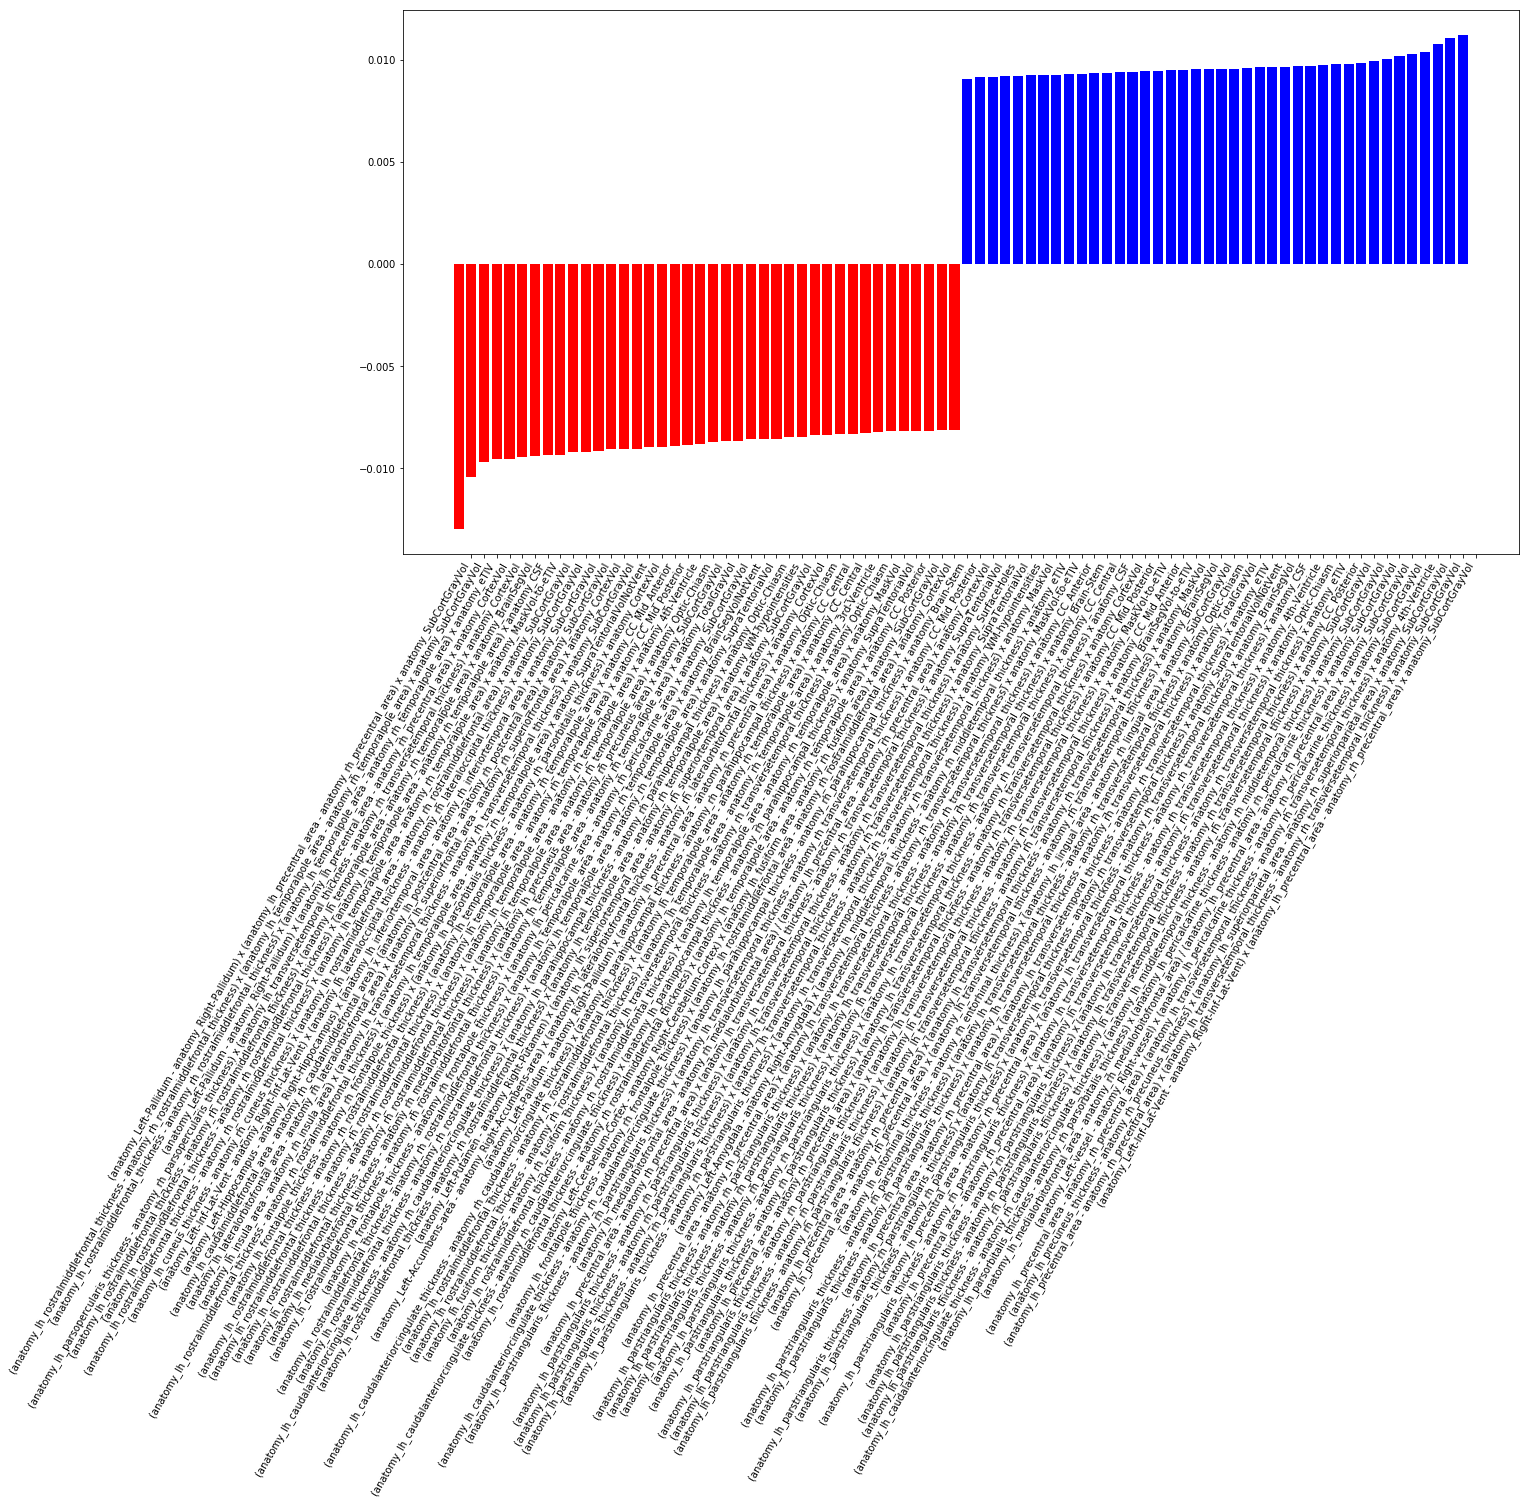

In [85]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [ ]:
coef = log_reg.coef_.ravel()

In [84]:
coef.min(), coef.max(), np.abs(coef).min()

(-0.01297162648667034, 0.011204569904394739, 9.982117880413818e-10)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


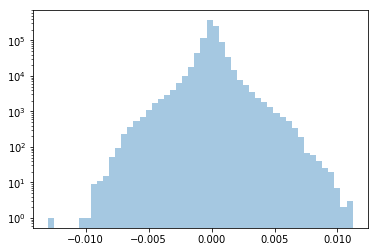

In [86]:
sns.distplot(coef, kde=False)
plt.yscale('log')

In [87]:
from itertools import product

In [88]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search

In [98]:
neg_thresholds = np.linspace(-0.0012, -0.0017, 10)
pos_thresholds = np.linspace(0.0012, 0.0017, 10)

In [99]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 30
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" -> ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_3_selected_columns = np.array(cols)[interesting_coefficients].tolist()
        
    results = evaluation(data3[top_3_selected_columns], data3['target'], verbose=False)
    
    current_roc = np.mean(results['test_roc_auc'])
    print(current_roc)
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping
    
    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.0012 0.0012 -> 0.756958244483765
Trial:  1 -0.0012 0.0012555555555555555 -> 

Process ForkPoolWorker-20576:
Process ForkPoolWorker-20573:
Process ForkPoolWorker-20574:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

In [96]:
best_thresholds

(-0.0015, 0.0015)

In [97]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(positive_coefficients), len(negative_coefficients), len(coef))


# interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
# top_3_selected_columns = np.array(cols)[interesting_coefficients].tolist()

# results = evaluation(data3[top_3_selected_columns], data2['target'])

# print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
#                                                         np.std(results['train_roc_auc'])))
# print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
#                                                           np.std(results['test_roc_auc'])))

# print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
#                                                          np.std(results['train_accuracy'])))
# print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
#                                                            np.std(results['test_accuracy'])))

-0.0015 0.0015
41156 41773 998800



```
-0.03932351273569926 0.022553479574011357
1576 716 40602

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.773 +- 0.013 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.714 +- 0.014
```

In [ ]:
print("[", end="")
for f in top_3_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

Compute correlations with target

In [106]:
corr12_inv = [
    data2[c].corr(data2['target']) for c in train_columns
]

sns.distplot(corr12_inv, kde=False)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


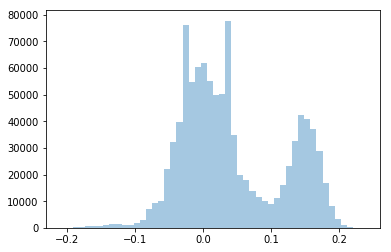

In [107]:
corr123_inv = [
    data3[c].corr(data3['target']) for c in triplet_columns
]

sns.distplot(corr123_inv, kde=False)

In [34]:
corr12_inv_ = pd.Series(corr12_inv, index=train_columns)

In [108]:
corr123_inv_ = pd.Series(corr123_inv, index=triplet_columns)

Filter duplicates and highly correlated features

In [123]:
# corr12_inv_approx = corr12_inv_.apply(lambda x: round(x, 5))
corr12_inv_approx = corr12_inv_

#filtered_corr12_inv_ = corr12_inv_approx[~corr12_inv_approx.duplicated()]
#filtered_corr12_inv_ = filtered_corr12_inv_[filtered_corr12_inv_.abs() > 0.017]
filtered_corr12_inv_ = corr12_inv_approx

In [124]:
filtered_corr12_inv_.shape, corr12_inv_.shape

((132497,), (132497,))

In [125]:
np.min(filtered_corr12_inv_), np.max(filtered_corr12_inv_)

(-0.17592430077456034, 0.20914977808094617)

In [27]:
# sns.distplot(filtered_corr12_inv_[filtered_corr12_inv_.index.str.contains("anatomy_3rd-Ventricle")], kde=False, bins=100)



In [29]:
# "anatomy_lh_superiorparietal_area x 1/(anatomy_3rd-Ventricle)" in filtered_corr12_inv_

In [30]:
# "anatomy_3rd-Ventricle x 1/(anatomy_lh_superiorparietal_area)" in filtered_corr12_inv_

In [35]:
filtered_corr12_inv_[filtered_corr12_inv_ < -0.17].sort_values()

anatomy_rh_caudalanteriorcingulate_thickness / anatomy_3rd-Ventricle   -0.175924
anatomy_lh_parahippocampal_thickness / anatomy_3rd-Ventricle           -0.174813
anatomy_rh_inferiorparietal_area / anatomy_3rd-Ventricle               -0.174039
anatomy_rh_isthmuscingulate_thickness / anatomy_3rd-Ventricle          -0.173304
anatomy_rh_precentral_thickness / anatomy_3rd-Ventricle                -0.172485
anatomy_rh_parahippocampal_thickness / anatomy_3rd-Ventricle           -0.170039
dtype: float64

In [36]:
filtered_corr12_inv_[filtered_corr12_inv_ > 0.185].sort_values()

anatomy_rh_rostralmiddlefrontal_thickness x anatomy_3rd-Ventricle                                                  0.185184
anatomy_3rd-Ventricle x (anatomy_lh_inferiorparietal_thickness + anatomy_rh_inferiorparietal_thickness)            0.185195
anatomy_rh_superiorfrontal_thickness x anatomy_3rd-Ventricle                                                       0.185755
anatomy_3rd-Ventricle x (anatomy_lh_entorhinal_thickness + anatomy_rh_entorhinal_thickness)                        0.185885
anatomy_lh_inferiorparietal_thickness x anatomy_3rd-Ventricle                                                      0.185918
anatomy_3rd-Ventricle x anatomy_lhCortexVol                                                                        0.186465
anatomy_3rd-Ventricle x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)    0.186683
anatomy_lh_rostralmiddlefrontal_thickness x anatomy_3rd-Ventricle                                                  0.187014
anatomy_

In [112]:
corr123_inv_[corr123_inv_ > 0.22].sort_values()

anatomy_SupraTentorialVol / (anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area) x anatomy_CC_Anterior                                                                       0.220052
(anatomy_Left-Putamen + anatomy_Right-Putamen) / (anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area) x anatomy_CC_Anterior                                                  0.220137
(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area) x anatomy_SupraTentorialVolNotVent                             0.220137
(anatomy_lh_parahippocampal_area + anatomy_rh_parahippocampal_area) / (anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area) x anatomy_SupraTentorialVolNotVent                0.220406
(anatomy_lh_insula_area + anatomy_rh_insula_area) / (anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area) x 

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


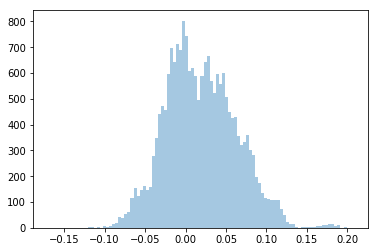

In [35]:

sns.distplot(corr12_inv_[corr12_inv_.index.str.contains(" x ")], kde=False, bins=100)


/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


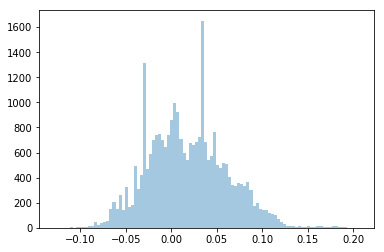

In [36]:

sns.distplot(corr12_inv_[corr12_inv_.index.str.contains(" \+ ")], kde=False, bins=100)


/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


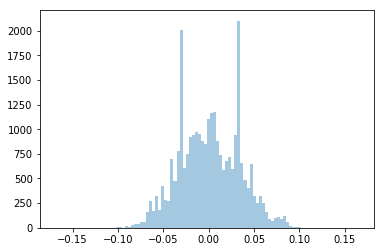

In [37]:

sns.distplot(corr12_inv_[corr12_inv_.index.str.contains(" - ")], kde=False, bins=100)


/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


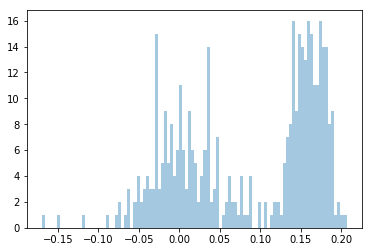

In [38]:

sns.distplot(corr12_inv_[corr12_inv_.index.str.contains("anatomy_3rd-Ventricle")], kde=False, bins=100)


In [40]:
corr12_inv_[(corr12_inv_ > 0.18) & corr12_inv_.index.str.contains("anatomy_3rd-Ventricle /")].sort_values()

anatomy_3rd-Ventricle / (anatomy_lh_rostralanteriorcingulate_area + anatomy_rh_rostralanteriorcingulate_area)    0.181835
dtype: float64

In [48]:
corr12_inv_[(corr12_inv_ > 0.13) & ~corr12_inv_.index.str.contains("anatomy_3rd-Ventricle")].sort_values()

(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)                0.130504
anatomy_CSF x (anatomy_lh_entorhinal_thickness + anatomy_rh_entorhinal_thickness)                                                                        0.130630
anatomy_CSF x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)                                                            0.130670
anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)                                                                       0.130870
(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)    0.131093
(anatomy_Left-Lateral-Ventricle + anatomy_Right-Lateral-Ventricle) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)               0.131183
(anatomy_Left-Amygdala + ana

In [37]:
# sns.distplot(filtered_corr12_inv_, kde=False, bins=100)

In [53]:
# cols = [c for c in filtered_corr12_inv_.index]

# corr_ = data2[cols].corr()

# s = pd.Series(corr12_inv_[cols], name="target")
# corr_ = pd.concat([corr_, s], axis=1)

# corr_.loc[:, '1/Q'] = corr_[cols].abs().sum() - corr_['target'].abs()

# corr_ = corr_.sort_values(by='1/Q')

# corr_.sort_values(by="target").tail()

# corr_['1/Q'].min(), corr_['1/Q'].max()

# sns.distplot(corr_['1/Q'], kde=False, bins=100)

# corr_threshold = (corr_['1/Q'].max() + corr_['1/Q'].min()) * 0.5
# corr_threshold

# corr_selected_columns = corr_[corr_['1/Q'] < corr_threshold].index.values.tolist()
# len(corr_selected_columns)

# corr_selected_columns[:10]

In [38]:
corr_selected_columns = filtered_corr12_inv_.index.values.tolist()
corr_selected_columns[:10], len(corr_selected_columns)

(['anatomy_lh_bankssts_area',
  'anatomy_lh_caudalanteriorcingulate_area',
  'anatomy_lh_caudalmiddlefrontal_area',
  'anatomy_lh_cuneus_area',
  'anatomy_lh_entorhinal_area',
  'anatomy_lh_fusiform_area',
  'anatomy_lh_inferiorparietal_area',
  'anatomy_lh_inferiortemporal_area',
  'anatomy_lh_isthmuscingulate_area',
  'anatomy_lh_lateraloccipital_area'],
 132497)

In [39]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

n_jobs=1
seed = 42


class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), 
                                 LogisticRegression(random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results


from problem import get_cv


def original_evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)    
    return results

Check `corr_selected_columns`

In [41]:
import numpy as np

results = evaluation(data2[corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.582 +- 0.033 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.567 +- 0.027


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  9.0min finished


```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.672 +- 0.019 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.627 +- 0.020
```

### Feature importance of extracted features

In [42]:
from sklearn.feature_selection import SelectFromModel

pipe = make_pipeline(StandardScaler(), LogisticRegression(C=100, n_jobs=1, random_state=seed))
log_reg = pipe.named_steps['logisticregression']
feature_selection = SelectFromModel(log_reg, prefit=True, threshold="4.0*mean")

In [59]:
pipe.fit(data2[corr_selected_columns], data2['target'])

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [60]:
np_corr_selected_columns = np.array(corr_selected_columns)

In [61]:
selected_corr_columns = feature_selection.transform(np_corr_selected_columns[None, :])[0].tolist()

In [62]:
len(selected_corr_columns), selected_corr_columns[:10], selected_corr_columns[-10:]

(343,
 ['participants_sex',
  '1/(anatomy_lh_rostralanteriorcingulate_area)',
  '1/(anatomy_lh_temporalpole_area)',
  '1/(anatomy_rh_caudalanteriorcingulate_area)',
  '1/(anatomy_rh_inferiorparietal_area)',
  '1/(anatomy_rh_isthmuscingulate_area)',
  '1/(anatomy_rh_parstriangularis_area)',
  '1/(anatomy_rh_rostralanteriorcingulate_area)',
  '1/(anatomy_Left-Lateral-Ventricle)',
  '1/(anatomy_3rd-Ventricle)'],
 ['(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness)',
  '(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area)',
  '(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness)',
  '(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (an

In [83]:
# log_reg = pipe.named_steps['logisticregression']

# coef = log_reg.coef_.ravel()
# positive_coefficients_2 = np.argsort(coef)
# negative_coefficients_2 = np.argsort(coef)

# coef.min(), coef.max(), np.abs(coef).min()

# sns.distplot(coef, kde=False)

# n_top_features = 400

# positive_coefficients = positive_coefficients_2[-n_top_features:]
# negative_coefficients = negative_coefficients_2[:n_top_features]
# interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

# top_corr_selected_columns = np.array(corr_selected_columns)[interesting_coefficients].tolist()



## Train a linear model 

In [63]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

n_jobs=1
seed = 42


class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), 
                                 LogisticRegression(random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


Check `corr_selected_columns`

In [64]:
import numpy as np

results = evaluation(data2[selected_corr_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.734 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.672 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


A reference with feature ^ 2
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.637 +- 0.014 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.604 +- 0.014
```

In [65]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [66]:
import numpy as np

results = evaluation(data2[selected_corr_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.969 +- 0.021
Validation score ROC-AUC: 0.751 +- 0.018 

Training score accuracy: 0.908 +- 0.037
Validation score accuracy: 0.684 +- 0.014


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished


```
Training score ROC-AUC: 0.969 +- 0.021
Validation score ROC-AUC: 0.751 +- 0.018 

Training score accuracy: 0.908 +- 0.037
Validation score accuracy: 0.684 +- 0.014

```

In [43]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [44]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

n_jobs=1
seed = 42


class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), 
                                 LogisticRegression(random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


### Feature importance of Corr selected features

In [45]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data2[corr_selected_columns], data2['target'])

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [46]:
log_reg2 = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

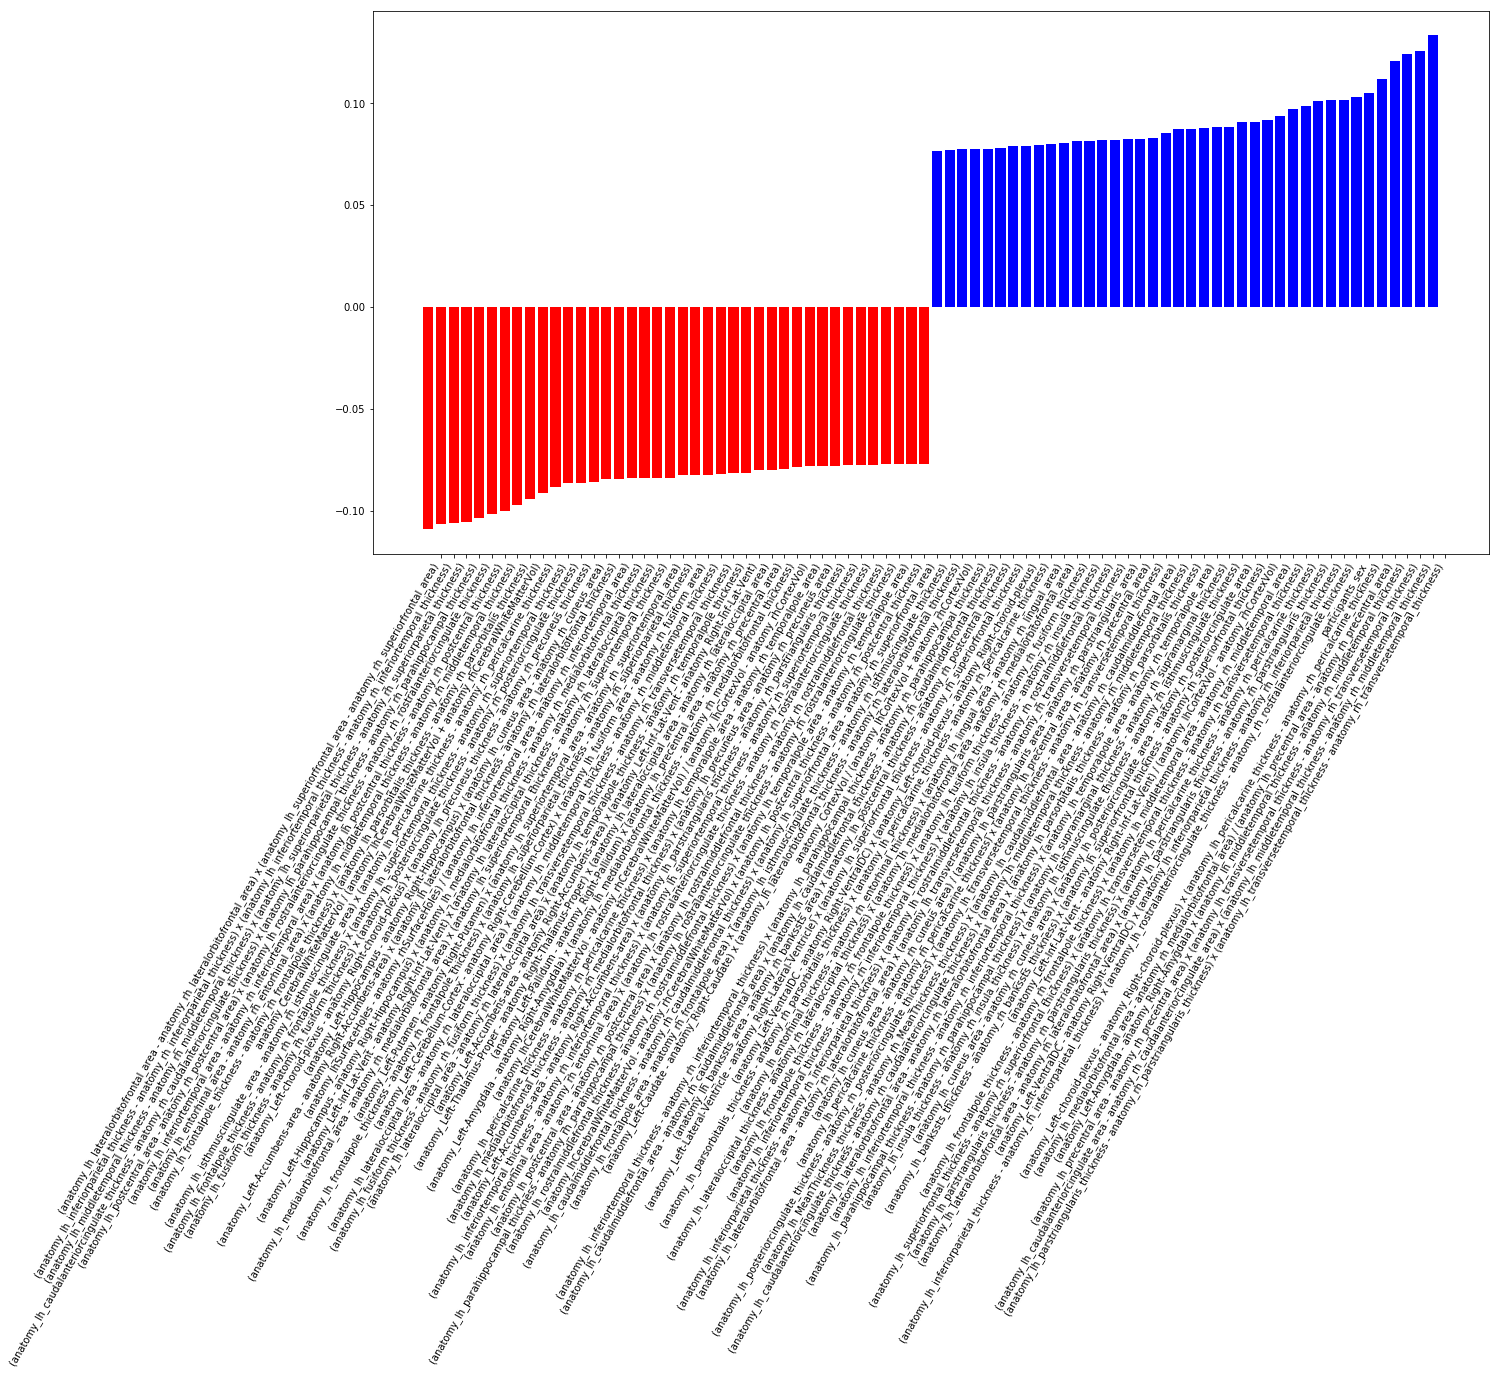

In [47]:
visualize_coefficients(log_reg2, feature_names=corr_selected_columns, n_top_features=40)

In [48]:
coef2 = log_reg2.coef_.ravel()

In [49]:
coef2.min(), coef2.max(), np.abs(coef2).min()

(-0.10917886111079757, 0.13343524581785654, 1.0040365728614716e-07)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


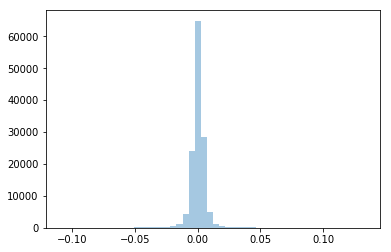

In [50]:
sns.distplot(coef2, kde=False)

In [99]:
neg_threshold = 0.08 * coef2.min()
pos_threshold = 0.075 * coef2.max()
neg_threshold, pos_threshold 

(-0.008734308888863805, 0.010007643436339241)

In [100]:
positive_coefficients = np.where(coef2 > pos_threshold)[0]
negative_coefficients = np.where(coef2 < neg_threshold)[0]

In [101]:
len(positive_coefficients), len(negative_coefficients)

(4253, 4991)

In [102]:
# n_top_features = 400
# positive_coefficients = positive_coefficients_2[-n_top_features:]
# negative_coefficients = negative_coefficients_2[:n_top_features]

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_corr_selected_columns = np.array(corr_selected_columns)[interesting_coefficients].tolist()

In [103]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [104]:
results = evaluation(data2[top_corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.001
Validation score ROC-AUC: 0.709 +- 0.031 

Training score accuracy: 0.998 +- 0.006
Validation score accuracy: 0.658 +- 0.024


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   47.3s finished


**config 2**

```
anatomy select in [1, 2]
corr12_inv_approx = corr12_inv_.apply(lambda x: round(x, 5))

filtered_corr12_inv_ = corr12_inv_approx[~corr12_inv_approx.duplicated()]
filtered_corr12_inv_ = filtered_corr12_inv_[filtered_corr12_inv_.abs() > 0.017]
```

(-0.07284712741455728, 0.07871920503407033)
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.764 +- 0.022 

Training score accuracy: 0.999 +- 0.001
Validation score accuracy: 0.694 +- 0.024
```




**config 1**

```
anatomy select < 2
corr12_inv_approx = corr12_inv_.apply(lambda x: round(x, 5))

filtered_corr12_inv_ = corr12_inv_approx[~corr12_inv_approx.duplicated()]
filtered_corr12_inv_ = filtered_corr12_inv_[filtered_corr12_inv_.abs() > 0.03]
```

(-0.08605396730502125, 0.07733905985162687)
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.765 +- 0.009 

Training score accuracy: 0.999 +- 0.002
Validation score accuracy: 0.697 +- 0.010
```

In [123]:
results = original_evaluation(data2[top_corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.844 +- 0.023 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.763 +- 0.030


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.1s finished




**config 2**
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.844 +- 0.023 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.763 +- 0.030
```



**config 1**
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.842 +- 0.024 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.762 +- 0.022
```

Try SVM

In [167]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
                
        params = {
            "C": np.logspace(-2, 5, num=12),
            "kernel": ["rbf", "linear"]
        }
        clf = SVC()
        pipe_cv = make_pipeline(StandardScaler(), 
                                GridSearchCV(clf, params, 
                                             n_jobs=8, 
                                             cv=StratifiedKFold(n_splits=5, random_state=seed),
                                             scoring="roc_auc"))
        pipe_cv.fit(X, y)
        best_params = pipe_cv.named_steps['gridsearchcv'].best_params_
        self.clf = make_pipeline(StandardScaler(), SVC(random_state=seed, probability=True, **best_params))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [168]:
results = evaluation(data2[top_corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.765 +- 0.013 

Training score accuracy: 0.999 +- 0.004
Validation score accuracy: 0.698 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


150 (0.088 Corr threshold)
```
Training score ROC-AUC: 0.970 +- 0.027
Validation score ROC-AUC: 0.765 +- 0.019 

Training score accuracy: 0.918 +- 0.051
Validation score accuracy: 0.700 +- 0.017
```

175 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.986 +- 0.009
Validation score ROC-AUC: 0.812 +- 0.014 

Training score accuracy: 0.946 +- 0.028
Validation score accuracy: 0.732 +- 0.012
```

160 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.985 +- 0.011
Validation score ROC-AUC: 0.811 +- 0.009 

Training score accuracy: 0.944 +- 0.030
Validation score accuracy: 0.733 +- 0.011
```

140 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.982 +- 0.012
Validation score ROC-AUC: 0.811 +- 0.012 

Training score accuracy: 0.937 +- 0.029
Validation score accuracy: 0.732 +- 0.015
```


140 (0.05 Corr threshold)
```
Training score ROC-AUC: 0.979 +- 0.018
Validation score ROC-AUC: 0.797 +- 0.006 

Training score accuracy: 0.933 +- 0.038
Validation score accuracy: 0.717 +- 0.010
```

Print features as a single line

In [90]:
# print("[", end="")
# for f in selected_columns:
#     print("\"{}\"".format(f), end=", ")
# print("]")

In [91]:
# print("[", end="")
# for f in top_corr_selected_columns:
#     print("\"{}\"".format(f), end=", ")
# print("]")